## To load the needed packages:

In [1]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import warnings, pickle
warnings.filterwarnings("ignore")
from astropy.wcs import WCS
# from galight.tools.astro_tools import plt_many_fits
from galight.data_process import DataProcess
from galight.tools.astro_tools import read_pixel_scale
from galight.fitting_specify import FittingSpecify
from galight.fitting_process import FittingProcess
import glob

## Input the filter ID for the fit. We show F150W for this example:

In [2]:
filt_i = 1
filt = ['F115W', 'F150W','F277W', 'F444W'][filt_i]
filefolder = '/Volumes/Seagate_Expansion_Drive/data_backup/JWST_COSMOS/COSMOSweb/' #Folder of the image
filename = 'mosaic_nircam_f{0}w_COSMOS-Web_30mas_v0_1_i2d.fits'.format(filt[1:-1])
fitsFile = pyfits.open(filefolder+filename)
header = fitsFile[1].header # if target position is add in WCS, the header should have the wcs information, i.e. header['EXPTIME']
img = fitsFile[1].data #
wcs = WCS(header)
#The entire image is huge and the making the plot takes time:
# from galight.tools.astro_tools import plt_fits
# plt_fits(img)

### Load the PSF library and plot them. One can use each PSF to see how results changes, by change psf_id later.

The RA and Dec of each PSF is in PSF_RA_DEC_list.

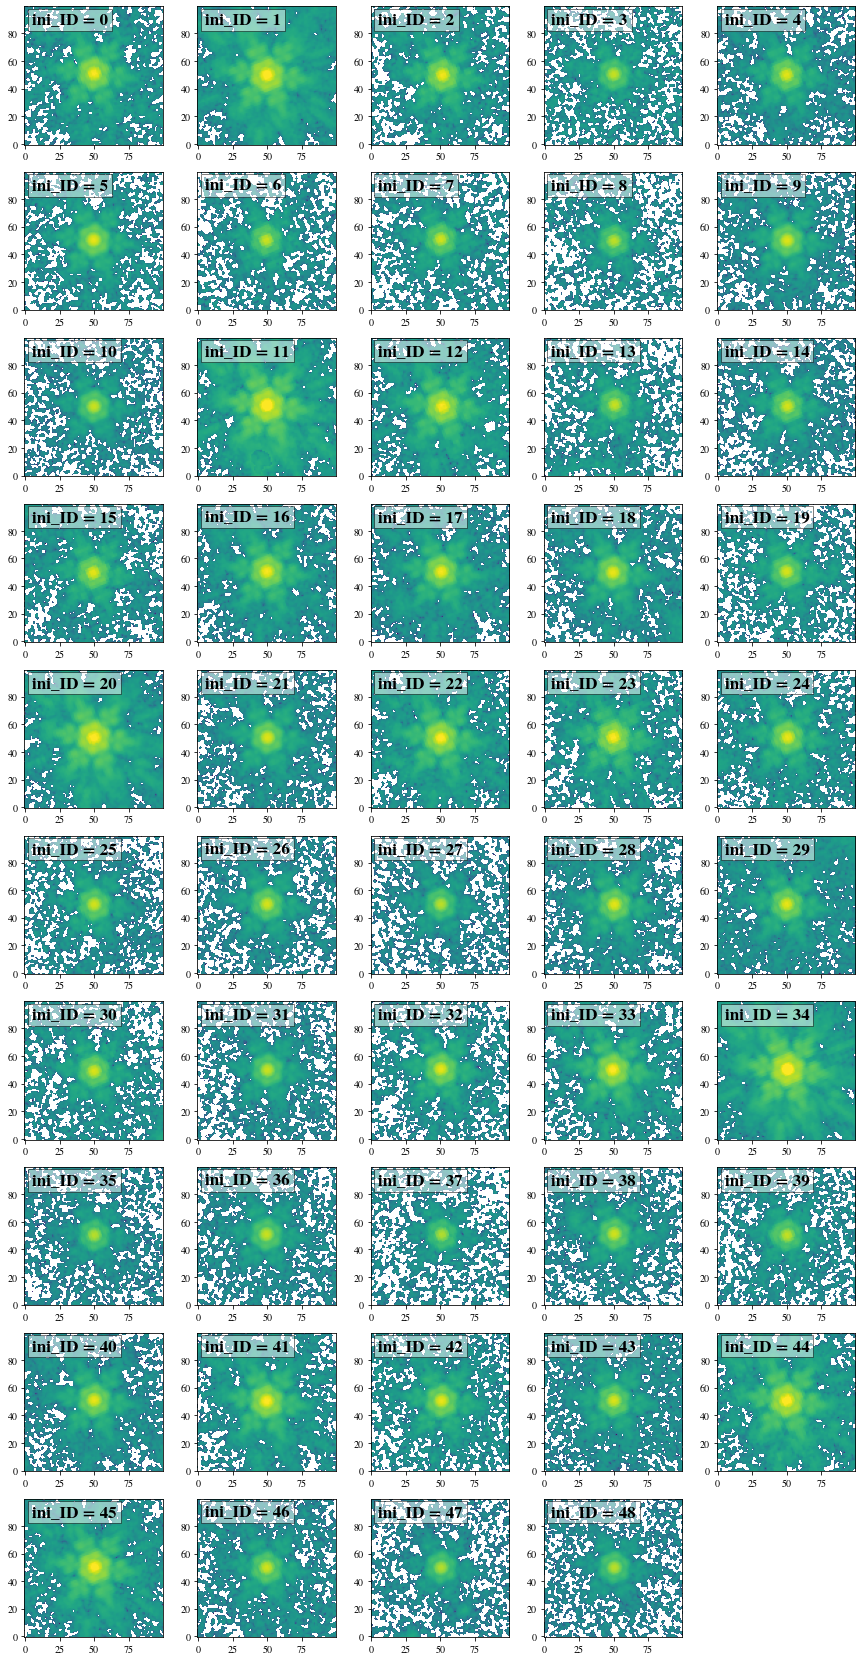

In [3]:
 from galight.tools.astro_tools import plt_many_fits
PSF_lib_files = glob.glob('PSF_library/'+filt+'_PSF_Library.pkl')[0]
PSF_org_list, PSF_clean_list, all_PSF_pos_list, PSF_RA_DEC_list = pickle.load(open(PSF_lib_files,'rb'))
plt_many_fits(PSF_clean_list)

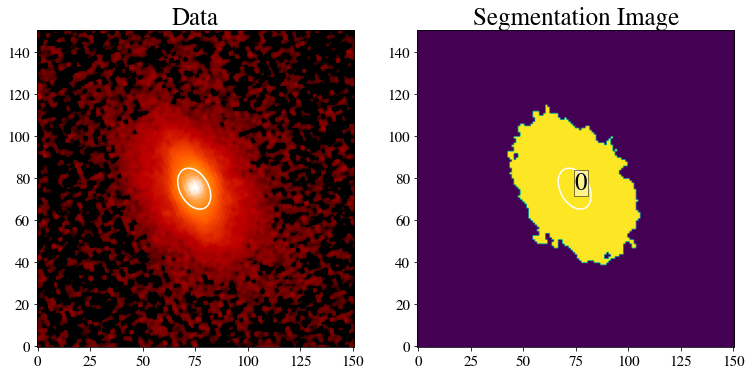

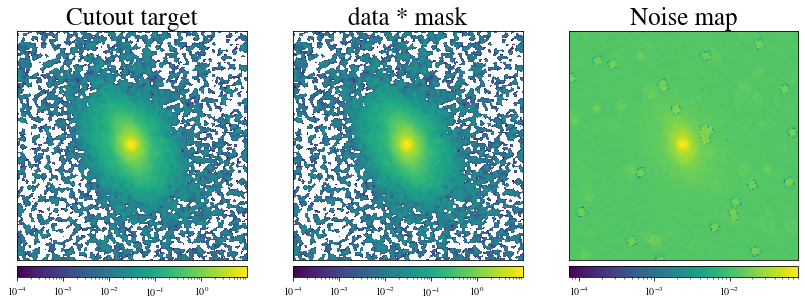

The settings for the fitting is done. Ready to pass to FittingProcess. 
  However, please make updates manullay if needed.


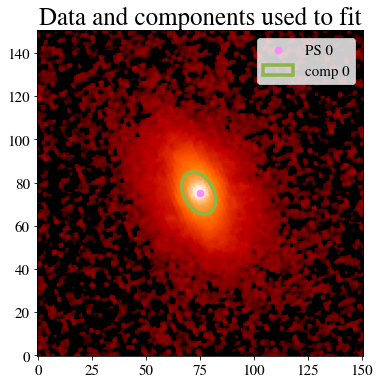

In [4]:
#Provide the Ra, Dec and name of your target:
RA, Dec, target_id = 149.9040069580078, 2.3863449096679688, 'cid_1188'
#Input the id of the PSF that will be used for the fitting.
psf_id = 0  #change 0 to other PSF id for testing.

flux_mjsr = header['PHOTMJSR']
pixscale = read_pixel_scale(header)
zp = -2.5*np.log10(2.350443 * 10**(-5) *pixscale**2/3631)
fov_noise_map = fitsFile[2].data
PSF = PSF_clean_list[psf_id]
PSF = PSF[1:,1:]  #Change PSF shape to an odd number
#%%    
from galight.tools.astro_tools import plt_fits
data_process = DataProcess(fov_image = img, target_pos = [RA, Dec], pos_type = 'wcs', header = header,
                          rm_bkglight = False, if_plot=False, zp = zp, fov_noise_map = fov_noise_map)
data_process.generate_target_materials(radius=75, 
                                       create_mask = False, nsigma=3, if_select_obj=False,
                                      exp_sz= 1.2, npixels = 100, if_plot=True)
data_process.noise_map[data_process.noise_map < 0.00025] = np.max(data_process.noise_map[data_process.noise_map!=0])
data_process.filt = filt

#To remove the FOV image since they are too huge...
del data_process.fov_image
del data_process.fov_noise_map


data_process.PSF_list = [PSF]
fit_sepc = FittingSpecify(data_process)
fit_sepc.prepare_fitting_seq(point_source_num = 1, supersampling_factor = 3, apertures_center_focus=True)

#The following will set the upper limit of the size of the component 0 as 0.4 arcsec.
fit_sepc.kwargs_params['lens_light_model'][4][0]['R_sersic'] = 0.4

#The following will set the bottom limit of the size of the component 0 as 0.03 arcsec.
fit_sepc.kwargs_params['lens_light_model'][3][0]['R_sersic'] = 0.03

#for PSF position interpolation, default is 1.
# fit_sepc.kwargs_numerics['point_source_supersampling_factor'] = 4

fit_sepc.plot_fitting_sets()

Computing the PSO ...
10
20
30
40
50
Max iteration reached! Stopping.
-2.4331568499500054 reduced X^2 of best position
-27727.038883605288 logL
22791.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.29772975490380466, 'n_sersic': 1.86831145641757, 'e1': -0.20367598825071342, 'e2': 0.1781156851357934, 'center_x': 0.00422519234189918, 'center_y': -0.03673637917181859}] lens light result
[{'ra_image': array([0.0207574]), 'dec_image': array([-0.01704212]), 'point_amp': array([1.])}] point source result
{} special param result
8.33020305633545 time used for  PSO
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Converged after 101 iterations!
Best fit found:  -27721.28336820399 [0.29848685792262786, 1.8688215895353255, -0.2030700637162051, 0.1791444032498167, 0.004163196652162771, -0.037172928575596426, 0.020094650804030445, -0.0164017321147039]
-2.432651780808564 reduced X^2 of best position
-27721.28336820399 logL
22791.0 effective number of d

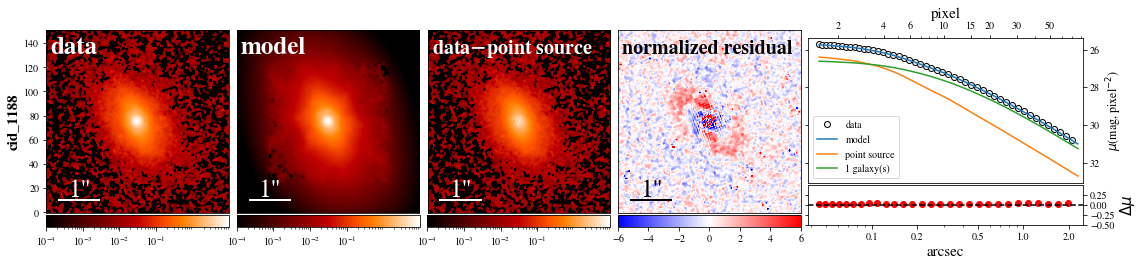

In [5]:
fit_run = FittingProcess(fit_sepc, savename = target_id)
fit_run.run(algorithm_list = ['PSO', 'PSO'], fitting_level=['norm','deep'])
fit_run.plot_final_qso_fit(target_ID =target_id, show_plot=True)
# %%For future load:
# fit_run = pickle.load(open('fit_{1}_{0}.pkl'.format(target_id,filt),'rb'))

In [6]:
print(fit_run.final_result_galaxy[0])
print("fitting reduced Chisq:", fit_run.reduced_Chisq)

{'amp': 1216.0468423786397, 'R_sersic': 0.29848685792262786, 'n_sersic': 1.8688215895353255, 'e1': -0.2030700637162051, 'e2': 0.1791444032498167, 'center_x': 0.004163196652162771, 'center_y': -0.037172928575596426, 'phi_G': 1.2093551975626817, 'q': 0.5738174247577777, 'flux_sersic_model': 982.7436002756415, 'flux_within_frame': 979.5318600811762, 'magnitude': 20.60903862360243}
fitting reduced Chisq: 2.4315849009999146


In [7]:
#To save the data with pickle.
fit_run.dump_result()

## You can reload your pickle result. 

### You can directly run this after you restart your terminal or sharing this pkl file with the collaborators. Note that you should make sure the galight, lenstronomy and astropy are in the same version to reload it.

In [8]:
import pickle
picklename = 'cid_1188.pkl'
fitting_run_result = pickle.load(open(picklename,'rb'))

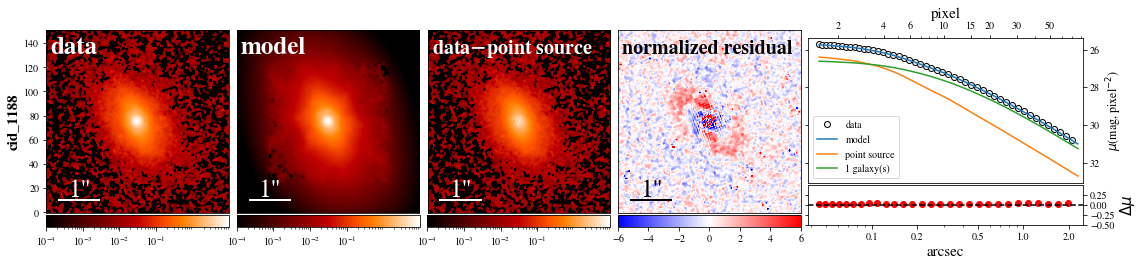

{'amp': 1216.0468423786397,
 'R_sersic': 0.29848685792262786,
 'n_sersic': 1.8688215895353255,
 'e1': -0.2030700637162051,
 'e2': 0.1791444032498167,
 'center_x': 0.004163196652162771,
 'center_y': -0.037172928575596426,
 'phi_G': 1.2093551975626817,
 'q': 0.5738174247577777,
 'flux_sersic_model': 982.7436002756415,
 'flux_within_frame': 979.5318600811762,
 'magnitude': 20.60903862360243}

In [11]:
fitting_run_result.plot_final_qso_fit(target_ID=target_id)
fitting_run_result.final_result_galaxy[0]